In [1]:
import findspark
findspark.init()

# Importing PYSPARK and the most used libraries
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
conf = pyspark.SparkConf().setMaster("local[*]").setAppName("CountingSheep")
spark_context = SparkSession.builder.config(conf=conf).getOrCreate()
from pyspark.sql.types import StructType, StructField, FloatType, BooleanType
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark import SQLContext
from pyspark.accumulators import AccumulatorParam

from sklearn import preprocessing
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import csv
import random
import enum
import time
import copy
from math import sqrt, atan, floor, ceil
spark.sparkContext._conf.getAll()
spark.sparkContext.setSystemProperty('spark.executor.memory', '8g')
import sys
spark.sparkContext.setSystemProperty('spark.executor.heartbeatInterval', '30s')
spark.sparkContext.setSystemProperty('spark.network.timeout ', '360s')

In [2]:
### SERIAL FUNCTIONS OF THE SKYLINE QUERIES
def bnl_skyline(data,weights = [1,1,1,1,1,1]):
    result = []
    islist = True
    if isinstance(data,list):
        True    
    else:
        data = list(data)
    stopFirst = min(len(weights), len(data[0]))
    stopFirstArray = range(stopFirst)
    
    data_copy = list(data)
    for ps in data:
        #potential skyline
        insert = True
        for subset in [result,data_copy]:
            for other in subset:
                # if it is dominated but does not dominate the datapoint then it is not a skyline point
                # if it is not dominated ever it is a skyline point
                # if it is dominated and also dominates then it is a tie and it can be a skyline point
                isDominated = False
                dominates = False
                for i in stopFirstArray:
                    if ps[i] < other[i] :
                        dominates = True
                    if ps[i] > other[i] :
                        isDominated = True
                if isDominated and not dominates :
                    insert = False
                    break
            if not insert:
                break
        data_copy.remove(ps)
        if insert:
                result.append(ps)  
    return result 
def nl_skyline(data,weights = [1,1,1,1,1,1]):
    result = []
    islist = True
    if isinstance(data,list):
        True    
    else:
        data = list(data)
    stopFirst = min(len(weights), len(data[0]))
    stopFirstArray = range(stopFirst)
    for ps in data:
        #potential skyline
        insert = True
        for other in data:
            # if it is dominated but does not dominate the datapoint then it is not a skyline point
            # if it is not dominated ever it is a skyline point
            # if it is dominated and also dominates then it is a tie and it can be a skyline point
            isDominated = False
            dominates = False
            for i in stopFirstArray:
                if ps[i] < other[i] :
                    dominates = True
                if ps[i] > other[i] :
                    isDominated = True
            if isDominated and not dominates :
                insert = False
                break
        if insert :
                result.append(ps)
                
    return result 

# SFS QUERY WITH SORTING
def sfs_query_serial(data, weights = [1,1,1,1,1,1,1,1]):
    values = []
    if not isinstance(data,list):
        data = list(data)
    # if data is empty
    if not data:
        return []
    stopFirst = min(len(weights), len(data[0]))
    data.sort()
    nd = []
    stopFirstArray = range(stopFirst)
    for ps in data:
        # ps : potentially non dominated point
        add = True
        for other in nd:
            dominated = False
            for k in stopFirstArray:
                if ps[k] < other[k] :
                    dominated = True # other point is dominated
                    break
            if dominated == True:
                continue
            add = False # default case is when
            break
        if add == True:
            nd.append(ps)
    return nd

# SFS QUERY WITHOUT SORTING
def sfs_query(data, weights = [1,1,1,1,1,1,1,1]):
    values = []
    nd = []
    islist = True
    stopFirst = 1
    if isinstance(data,map):
        mapValue = next(data)
        islist = False
        stopFirst = min(len(weights), len(mapValue))
        nd.append(mapValue)
    elif data:
        stopFirst = min(len(weights), len(data[0]))

    stopFirstArray = range(stopFirst)
    for ps in data:
        # ps : potentially non dominated point
        # ps = data[i]
        add = True
        for other in nd:
            dominated = False
            for k in stopFirstArray:
                if ps[k] < other[k] :
                    dominated = True
                    break
            if dominated == True:
                continue
            add = False
            break
        if add == True:
            nd.append(ps)
    return nd

In [3]:
### Data generation configuration

# Type of dataset generation
class DataGenEnum(enum.Enum):
    antiCorrelated = 1
    anticorrelated = 1
    Anticorrelated = 1
    AntiCorrelated = 1
    correlated = 2
    Correlated = 2
    Independent = 3
    independent = 3
    
    
class DataGenConfig():
    def __init__(self, typeOfCorrelation = DataGenEnum.independent, 
                 dataRange = [0,1], avg = 0.5, skylinePercentage = 1,
                 numberOfData = 10**6, numberOfDimensions = 4,
                 spreadPercentage = 10): 
        self.typeOfCorrelation = typeOfCorrelation
        self.dataRange = dataRange
        # UNUSED Variable
        self.avg = avg
        self.skylinePercentage = skylinePercentage
        self.numberOfData = numberOfData
        self.numberOfDimensions = numberOfDimensions
        self.spreadPercentage = spreadPercentage
        
    def setCorrelated(self):
            self.typeOfCorrelation = DataGenEnum.correlated
    def setAntiCorrelated(self):
            self.typeOfCorrelation = DataGenEnum.antiCorrelated
    def setIndependent(self):
            self.typeOfCorrelation = DataGenEnum.independent 
            
    def setNumberOfData(self, numData):
        self.numberOfData = numData
    
# Method that  creates the different types of datasets based on the distribution   
def dataGenerator(dataConfiguration = None):
    if dataConfiguration == None :
        dataConfiguration = DataGenConfig()
        
    typeOfCorrelation = dataConfiguration.typeOfCorrelation
    dataRange = dataConfiguration.dataRange
    avg = dataConfiguration.avg
    skylinePercentage = dataConfiguration.skylinePercentage
    numberOfData = dataConfiguration.numberOfData
    numberOfDimensions = dataConfiguration.numberOfDimensions
    spreadPercentage = dataConfiguration.spreadPercentage
    
    minDataValue = dataRange[0]
    maxDataValue = dataRange[1]
    data = []
    if typeOfCorrelation == DataGenEnum.independent:
        for i in range(numberOfData):
            datum = []
            for i in range(numberOfDimensions):
                datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            data.append(datum)
    elif typeOfCorrelation == DataGenEnum.correlated:
        for i in range(numberOfData):
            datum = []
            datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            relatedValue = datum[0]
            spread = spreadPercentage * 0.01
            for i in range(1, numberOfDimensions):
                datum.append(relatedValue + ((random.random()-0.5)*spread) )
            data.append(datum)
    else: #typeOfCorrelation = antiCorrelated
        for i in range(numberOfData):
            datum = []
            datum.append(random.random()*(maxDataValue-minDataValue)+minDataValue)
            relatedValue = maxDataValue-datum[0]
            spread = spreadPercentage * 0.01
            for i in range(1, numberOfDimensions):
                datum.append(relatedValue + (relatedValue*(random.random()-0.5)*spread) )
            data.append(datum)
    return data



In [4]:
# Container Object
class Result:
    def __init__(self, resultList, timeTaken, otherObject = []):
        self.resultList = resultList
        self.timeTaken = timeTaken
        self.otherObject = otherObject


In [5]:
## Parallel implementations of SKYLINE QUEREIS without grid or angular partitioning
print('Parallel implementations of SKYLINE QUERIES with fair partitioning methods.\nSuch as random partitioning of poitns or sorting and then partitioning points')
def execute_sfs(input_list, dimensions):
    i = 0
    allTuplesList = []
    newTupleAsList = []
    nd  = []
    # creation of tuples could be parallelized by glom, although we do not know the length of the list
    for el_list in input_list:
        for el in el_list:
            if i == dimensions:
                i = 0
                allTuplesList.append( tuple(newTupleAsList) )
                newTupleAsList = []
            newTupleAsList.append(el)
            i = i+1
    allTuplesList.append( tuple(newTupleAsList) )
    localSky = sfs_query_serial(allTuplesList)
    return localSky

def parallel_sfs(dataAsList, numberOfSlices = -1, show = False, sort = True):
    if numberOfSlices <= 0:
        numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataAsList)/1024/1000) * 0.4 ) ), 24)
    print('NumSlices: ' + str(numberOfSlices))
    numColumns = len(dataAsList[0])
    start = time.time()
    initialResult = spark.sparkContext.parallelize(dataAsList, numberOfSlices).sortBy(lambda x: x[0]).mapPartitions(sfs_query)
    initialResult = initialResult.collect()
    end = time.time()-start
    
    print('Length of first pass of parallel sfs is: ' + str(len(initialResult)))
    print('Time taken by the parallel section of SFS: ' + str(end))
    initialResult = [list(x) for x in initialResult ]
    start_serial = time.time()
    finSky = sfs_query_serial(initialResult)
    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(finSky)))
    print('Time taken by the serial section of SFS: ' + str(end_serial))
    print('Time taken in total for SFS execution: ' + str(end_serial+end))
    if show :
        helperVisualFunct(ddbb)
        helperVisualFunct(finSky,'Parallel sfs skyline')
        plt.show()
        if numColumns > 2 :
            show3D(ddbb)
            show3D(finSky)
    res = Result(finSky, end+end_serial)
    return res

def parallel_sfs_random(dataAsList, numberOfSlices = -1, show = False, sort = True):
    if numberOfSlices <= 0:
        numberOfSlices = min(max(8,  ceil((sys.getsizeof(dataAsList)/1024/1000) * 0.4 ) ), 24)
    print('NumSlices: ' + str(numberOfSlices))
    numColumns = len(dataAsList[0])
    start = time.time()
    initialResult = spark.sparkContext.parallelize(dataAsList, numberOfSlices).mapPartitions(sfs_query_serial)
    initialResult = initialResult.collect()
    end = time.time()-start
    
    print('Length of first pass of parallel sfs random is: ' + str(len(initialResult)))
    print('Time taken by the parallel section of SFS random: ' + str(end))
    initialResult = [list(x) for x in initialResult ]
    start_serial = time.time()
    finSky = sfs_query_serial(initialResult)
    end_serial = time.time() - start_serial
    print('Length of the skyline: ' + str(len(finSky)))
    print('Time taken by the serial section of SFS random: ' + str(end_serial))
    print('Time taken in total for SFS execution random: ' + str(end_serial+end))
    if show :
        helperVisualFunct(ddbb)
        helperVisualFunct(finSky,'Parallel sfs skyline')
        plt.show()
        if numColumns > 2 :
            show3D(ddbb)
            show3D(finSky)
    res = Result(finSky, end+end_serial)
    return res


def parallel_bnl(dataAsList, numberOfSlices = 16, show = False):
    ddbb = dataAsList
    start = time.time()
    weights = [1,1,1,1,1,1,1,1,1]
    initialResult = spark.sparkContext.parallelize(ddbb, numberOfSlices).mapPartitions(bnl_skyline).collect()
    finSky = bnl_skyline(initialResult, weights)
    end = time.time()-start
    print('Length of first pass of parallel BNL is: ' + str(len(initialResult)))
    print('Time taken by the parallel implementation of BNL: ' + str(end))
    if show :
        helperVisualFunct(ddbb)
        helperVisualFunct(finSky,'Parallel sfs skyline')
        plt.show()
        if len(ddbb[0]) > 2 :
            show3D(ddbb)
            show3D(finSky)
    res = Result(finSky, end)
    return res

def execute_bnl(input_list, dimensions, weights):
    i = 0
    allTuplesList = []
    newTupleAsList = []
    # creation of tuples could be parallelized by glom, although we do not know the length of the list
    for el_list in input_list:
        for el in el_list:
            if i == dimensions:
                i = 0
                allTuplesList.append( tuple(newTupleAsList) )
                newTupleAsList = []
            newTupleAsList.append(el)
            i = i+1
    allTuplesList.append( tuple(newTupleAsList) )
    localSky = bnl_skyline(allTuplesList, weights)
    return localSky

Parallel implementations of SKYLINE QUERIES with fair partitioning methods.
Such as random partitioning of poitns or sorting and then partitioning points


In [6]:
# We use DataFrames to create the SQL Query of the skyline
# This query benefits from the catalyst optimizer, although RDDs do not
# This query performs many times better than RDD implementations for lower data cardinalities
def sqlSkyline(dataArray, debug = False):
    numColumns = len(dataArray[0])
    structFieldArray = []
    
    for i in range(numColumns):
        if type(dataArray[0][i]) == int :
            structFieldArray.append(StructField('x'+str(i), IntegerType(),True))
        if type(dataArray[0][i]) == float :
            structFieldArray.append(StructField('x'+str(i), FloatType(),True))
        if type(dataArray[0][i]) == str :
            continue
        
    schema = StructType(structFieldArray)
    p = spark.createDataFrame(dataArray, schema = schema)
    dataArray = []
    if debug == True:
        p.show()
    p.createOrReplaceTempView("Z1")
    condition = ''
    for i in range(numColumns):
        condition = condition + 'p1.x' + str(i) + '<=p.x' + str(i) + ' AND '
    condition = condition + '('
    for i in range(numColumns):
        if i != numColumns -1 :
            condition =condition + 'p1.x' + str(i) + '<p.x' + str(i) + ' OR '
        else : 
            condition = condition + 'p1.x' + str(i) + '<p.x' + str(i) + ') )'
    
    sqlQuery = 'SELECT * FROM Z1 p WHERE NOT EXISTS(SELECT * FROM Z1 p1 WHERE ' + condition
    # The query here is : 
    # SELECT * FROM Z1 p WHERE NOT EXISTS
    #                                    (SELECT * FROM Z1 p1 WHERE p1.x1 <= p.x1 AND p1.x2 <= p.x2 AND etc.. AND
    #                                                     (p1.x1 < p.x1 OR p1.x2 < p.x2 OR etc.. ) ) 
    start = time.time()
    partialRes = spark.sql(sqlQuery)
    points = partialRes.collect()
    end = time.time() - start
    if debug == True:
        print(sqlQuery)
        partialRes.show()
    print('Time taken by the SQL Query: ' + str(end))
    
    p.unpersist()
    spark.catalog.dropTempView("Z1")
    return Result(points, end)

In [7]:
# Angular partitioning
print('Naive angular partitioning')
# calculate index
def getPartitionIndex(datapoint, dimensions, numSlices = 16):
    angleSQ = 0
    for i in range(dimensions):
        angleSQ = angleSQ + datapoint[i]**2
        
    anglesArray = []
    ## first is radius then all angles
    for i in range(dimensions):
        if i == 0:
            # radius
            continue
        else:
            angleSQ = angleSQ - (datapoint[i-1]**2) 
            angleSQ = max(0,angleSQ)
            if datapoint[i-1] == 0:
                value = sqrt(angleSQ) / (0.0001)
            else:
                value = sqrt(angleSQ) /  datapoint[i-1]
        anglesArray.append(value)
    radToDeg = 57.2957795
    piHalf = 1.57
    twoByPi = 0.636619772
    index = 0
    twoByPiNumSlices = twoByPi*numSlices
    for i in range(len(anglesArray)):
        index = index + floor(atan(anglesArray[i])*twoByPiNumSlices) * (numSlices**i)
    return index

#unpack each data by it's first index
def execute_sfs_indexed(input_list, dimensions, weights):
    i = 0
    newList = []
    nd = []
    isFirst = True
    for el_list in input_list:
        for el in el_list:
            if i % 2 == 1:
                ps = el
                nd.append(ps)
            i = i + 1
    nd = sfs_query_serial(nd,[1,1,1,1,1,1,1,1])
    return nd

def execute_sfs_serial(input_list, dimensions, weights):
    i = 0
    allTuplesList = []
    newTupleAsList = []
    nd  = []
    for el_list in input_list:
        for el in el_list:
            if i == dimensions:
                i = 0
                allTuplesList.append( tuple(newTupleAsList) )
                newTupleAsList = []
            newTupleAsList.append(el)
            i = i+1
    allTuplesList.append( tuple(newTupleAsList) )
    localSky = sfs_query_serial(allTuplesList, weights)
    return localSky
    
def parallel_angled_partitioning(dataArray, numSlices = 16):
    print('AP: Number of slices : ' + str(numSlices))
    dimensions = len(dataArray[0])
    weights = [1,1,1,1,1,1]
    start = time.time()
    # Partition By divides the dataset by the primary key of each tuple
    m2 = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .map(lambda x : ( getPartitionIndex(x,dimensions,numSlices)  , x) )  \
                    .partitionBy(numSlices**(dimensions-1)) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, dimensions, weights), preservesPartitioning=True)  \
                    .collect()
    end = time.time()- start
    print('Time taken for parallel section in AP: ' + str(end))
    print('AP: Length of initial Pass is :' + str(len(m2)))
    seq_time = time.time()
    finRes = sfs_query_serial(m2, weights)
    end_seq = time.time() - seq_time

    print('AP: Length of the skyline is :' + str(len(finRes)))
    print('AP: Sequential time taken: ' + str(end_seq))
    print('AP: Total Time: ' + str(end+end_seq))
    return Result(finRes,end+end_seq)


def sfs_query_with_memory(data, memory, weights = [1,1,1,1,1,1,1,1]):
    values = []
    nd = memory
    stopFirst = min(len(weights), len(memory[0]))
    stopFirstArray = range(stopFirst)
    for ps in data:
        # ps : potentially non dominated point
        add = True
        for other in nd:
            dominated = False
            for k in stopFirstArray:
                if ps[k] < other[k] :
                    dominated = True # other point is dominated
                    break
            if dominated == True:
                continue
            add = False # default case is when
            break
        if add == True:
            nd.append(ps)
    return nd


Naive angular partitioning


In [8]:
# Grid partitioning
print('Grid partitioning with a serial grid filtering phase')
class Container:
    def __init__(self, pointFound = [], dataContained = []):
        self.pointFound = pointFound
        self.dataContained = dataContained
        
    def addPoint(self, dataPoint):
        if len(dataPoint) != len(pointFound):
            raise Exception('Datapoint dimension not consistent with container point`s dimensions: ' \
                            + str(len(dataPoint)) + \
                            ' ' + len(pointFound))
        dataContained.add(dataPoint)

import numpy as np

def normalize_data(data):
    return ( 0.999999*(data - np.min(data))) / (np.max(data) - np.min(data)).tolist()
        
def sfs_query_for_containers(containerList, weights=[1,1,1,1,1,1,1]):
    stopFirst = min(len(weights),len(containerList[0].pointFound))
    nd = []
    stopFirstArray = range(stopFirst)
    for i in range(len(containerList)):
        if not containerList[i].dataContained: #if dataContained array is not empty
            continue
        # ps : potentially non dominated point
        ps = containerList[i].pointFound
        add = True
        for other in nd:
            dominated = False
            for k in stopFirstArray:
                if ps[k] <= other.pointFound[k] :
                    dominated = True
                    break
            if dominated == True:
                continue
            add = False
        if add == True:
            ps = containerList[i]
            nd.append(ps)
    return nd        

# Finds the skyline of grid containers based on its representative point
def query_containers(datapoints, dimensions, numSlicesPerDimension = 8, initialStepLen = -1):
    if initialStepLen == -1:
        initialStepLen = len(datapoints)
    limit = 1 / (numSlicesPerDimension)
    print('iterating - limit: ' +str(limit))
    num_slices_in_space = numSlicesPerDimension**dimensions
    containerList = []
    # create N square containers with each container having the datapoints contained and an index
    range_dim = range(dimensions)
    for i in range(num_slices_in_space): 
        point = []
        for j in range_dim:
            index = floor( i / (numSlicesPerDimension**j) ) % numSlicesPerDimension
            point.insert(j, index * limit + limit)
        containerList.insert(i+1, Container(point, []))
        
    for dp in datapoints:
        index = 0
        for i in range(len(dp)):
            if dp[i] >= 1:
                index = index + floor(0.99999 / limit) * (numSlicesPerDimension**i)
            else:
                index = index + floor(dp[i] / limit) * (numSlicesPerDimension**i)
        (containerList[index].dataContained).append(dp)
    resultingContainers = sfs_query_for_containers(containerList)
    input_list = []
    for container in resultingContainers:
        input_list = input_list + container.dataContained
    if len(input_list) <= initialStepLen * 0.80 :
        # if we discarded 20% of the previous step list's length then we do another step
        input_list = query_containers(normalize_data(input_list), dimensions, numSlicesPerDimension, len(input_list))
    return input_list

# Works for normalized data [0,1) only 
# Grid partitioning but with a serial filtering phase 
def sfs_index_squares(datapoints, dimensions = -1, numSlicesPerDimension = 12):
    if dimensions == -1:
        dimensions = len(datapoints[0])
    if numSlicesPerDimension <= 1:
        if dimensions <= 4:
            numSlicesPerDimension = 12
        else:
            numSlicesPerDimension = 5
    start = time.time()
    input_list = query_containers(datapoints, dimensions, numSlicesPerDimension)
    end = time.time() - start
    print(str(end) + ' for the container serial query')
    print('After first pass list length: ' + str(len(input_list)))
    print('After first pass list Size: ' + str(sys.getsizeof(input_list)/1024) + 'KB')
    numSlices = 12
    print('Num slices has been decided to be: ' + str(numSlices))
    start_parallel = time.time()
    finalResult = parallel_sfs(input_list, numSlices)
    end_parallel = time.time() - start_parallel
    print(str(end_parallel) + ' for the parallel_sfs query')
    print(str(end_parallel+end) + ' = total')
    return Result(finalResult.resultList, end_parallel+end)


Grid partitioning with a serial grid filtering phase


In [9]:
# Radius Partitioning
print('Radius partitioning with succesive angular partitioning skyline query')
def sfs_query_serial_with_memory(data, memory, weights = [1,1,1,1,1,1,1,1]):
    values = []
    mergeSort(data)
    nd = memory
    stopFirst = min(len(weights), len(memory[0]))
    stopFirstArray = range(stopFirst)
    for ps in data:
        # ps : potentially non dominated point
        add = True
        for other in nd:
            dominated = False
            for k in stopFirstArray:
                if ps[k] < other[k] :
                    dominated = True # other point is dominated
                    break
            if dominated == True:
                continue
            add = False # default case is when
            break
        if add == True:
            nd.append(ps)
    return nd

def execute_sfs_indexed_with_memory(input_list, memory_list):
    i = 0
    newList = []
    allTuples = []
    isFirst = True
    indexKey = 0
    for el_list in input_list:
        for el in el_list:
            if i % 2 == 1:
                ps = el
                allTuples.append(ps)
            i = i + 1
    nd = sfs_query_serial_with_memory(allTuples, memory_list,[1,1,1,1,1,1,1,1])
    return nd
    
def find_in_radius(input_list, dimensions, beginning = 0.0 ,radius = 0.2):
    angleSQ = 0
    i = 0
    point_radius = 0
    squared_radius = radius * radius
    squared_beginning = beginning * beginning
    newTupleAsList = []
    allTuplesList = []
    for el_list in input_list:
        for el in el_list:
            newTupleAsList.append(el)
            point_radius = point_radius + (el * el)
            i = i+1
            if i == dimensions:
                i = 0
                if point_radius <= squared_radius and squared_beginning <= point_radius: 
                    allTuplesList.append( tuple(newTupleAsList) )
                newTupleAsList = []
                point_radius = 0
    if point_radius <= squared_radius and squared_beginning <= point_radius: 
        allTuplesList.append( tuple(newTupleAsList) )
    allTuplesList = [x for x in allTuplesList if x]
    return allTuplesList
    
def parallel_radius_partitioning(dataArray, radius = 0.5, numSlices = 16):
    dimensions = len(dataArray[0])
    weights = [1,1,1,1,1,1,1]
    start_1 = time.time()
    dataArray = NormalizeData(dataArray).tolist()
    # we get the first few datapoints that have a lot of weight, being inside the unit circle
    m1 = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .mapPartitions(lambda x : find_in_radius(x, dimensions, beginning = 0, radius = radius)) \
                    .collect()
    m1 = spark.sparkContext.parallelize(m1, numSlices) \
                    .sortBy(lambda x: x[0])\
                    .mapPartitions(sfs_query) \
                    .collect()
    # we pass these datapoints to every parallel logic unit so that they can filter skyline points better
    end_1 = time.time() - start_1
    start = time.time()
    m2 = spark.sparkContext.parallelize(dataArray, numSlices) \
                    .mapPartitions(lambda x : find_in_radius(x, dimensions, beginning = radius,radius = 2))  \
                    .map(lambda x : (getPartitionIndex(x,len(x),numSlices),x))  \
                    .partitionBy(numSlices) \
                    .mapPartitions(lambda x : \
                                   execute_sfs_indexed_with_memory(x, m1), preservesPartitioning=True)  \
                    .collect()
    end = time.time() - start
    seq_time = time.time()
    finRes = sfs_query_serial(m2, weights)
    end_seq = time.time() - seq_time

    print('Length of 1st Pass is :' + str(len(m1)))
    print('Length of 2nd Pass is :' + str(len(m2)))
    print('Length of the skyline :' + str(len(finRes)))
    print('Time taken in parallel section 1st pass: ' + str(end_1))
    print('Time taken in parallel section 2nd pass: ' + str(end))
    print('Sequential time taken: ' + str(end_seq))
    print('Total Time: ' + str(end+end_seq+end_1))
    return Result(finRes,end+end_seq+end_1)

Radius partitioning with succesive angular partitioning skyline query


In [10]:
print('Helper methods for Representative filtering.')
def get_best_representatives(index, dataset, n = 30):
    # index is the dimension which we should check
    # is a tuple with area_covered as the first element and the n-dimensional point as the second element
    best_n_points = []
    limit = 1/n # default is 0.01
    for i in range(n):
        best_n_points.append((0,[]))
    counter = 0
    for point in dataset:
        counter = counter + 1
        area_covered = 1
        for element in point:
            area_covered = area_covered * (1-element)
        rep_index = floor(point[index]/limit)
        if best_n_points[rep_index][0] < area_covered:
            best_n_points[rep_index] = (area_covered, point)
    best_n_points = [x[1] for x in best_n_points if x[1]]
    return best_n_points


def filter_with_memory(datapoints, reps, onlyFilter = False):
    values = []
    nd = []
    stopFirst = len(reps[0])
    stopFirstArray = range(stopFirst)
    for ps in datapoints:
        # ps : potentially non dominated point
        add = True
        for rep in reps:
            dominated = False
            eq_dim = 0
            for k in stopFirstArray:
                if ps[k] < rep[k] :
                    dominated = True # other point is dominated
                    break
                elif ps[k] == rep[k]:
                    eq_dim = eq_dim + 1
            if dominated == True or eq_dim == stopFirst:
                continue
            add = False # default case is when
            break
        if add == True:
            nd.append(ps)
    if onlyFilter:
        return nd
    return sfs_query(nd)


def execute_sfs_no_sort(input_list, dimensions):
    i = 0
    allTuplesList = []
    newTupleAsList = []
    nd  = []
    # creation of tuples could be parallelized by glom, although we do not know the length of the list
    for el_list in input_list:
        for el in el_list:
            if i == dimensions:
                i = 0
                allTuplesList.append( tuple(newTupleAsList) )
                newTupleAsList = []
            newTupleAsList.append(el)
            i = i+1
    allTuplesList.append( tuple(newTupleAsList) )
    allTuplesList.sort(key=lambda x: x[0])
    localSky = sfs_query(allTuplesList)
    return localSky

Helper methods for Representative filtering.


In [11]:
# PARALLEL SFS With Representative filtering
print('SFS Query with Representative filtering.')
def parallel_sfs_with_representatives(dataAsList, slicesForSorting = -1, onlyFilter = False, givenReps = [], numberReps = 30):
    if slicesForSorting < 0:
        slicesForSorting = 12
    print('Slices for representative skyline ' + str(slicesForSorting))
    start_indexing = time.time()
    if givenReps == []:
        representatives = spark.sparkContext.parallelize(dataAsList, len(dataAsList[0]) ) \
                                    .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y, n = numberReps)) \
                                    .collect()
    else:
        representatives = givenReps
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))
    representatives = sfs_query_serial(representatives)
    print('Length of representatives after skyline query: ' + str(len(representatives)))
    start_parallel = time.time()
    parallel_skyline = []
    
    parallel_skyline = spark.sparkContext.parallelize(dataAsList, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives, onlyFilter = True)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    
    print('Time taken to filter: ' +str(end_parallel))
    print('Length of the after filter: ' + str(len(parallel_skyline)))
    start = time.time()
    parallel_skyline.sort(key=lambda x: x[0])
    parallel_skyline = spark.sparkContext.parallelize(parallel_skyline, slicesForSorting)\
                            .mapPartitions(lambda x : execute_sfs_no_sort(x, len(parallel_skyline[0]) )) \
                            .collect()
    
    end = time.time() - start
    
    print('Time taken to find the local skylines: ' +str(end))
    print('Length of parallel skyline: ' + str(len(parallel_skyline)))
    print('Final Serial stage:')
    start_serial = time.time()
    finRes = sfs_query_serial(parallel_skyline)
    end_serial = time.time() - start_serial
    print('~~~~~ Time taken to find the global skyline : ' +str(end_serial))
    print('~~~~~ Length of the skyline: ' + str(len(finRes)))
    print('~~~~~ Total time taken with representatives: ' + str(end_serial+end_parallel+end_indexing+end))
    return Result(finRes,end_serial+end_parallel+end_indexing+end)

SFS Query with Representative filtering.


In [12]:
# SFS Query with representatives
print('SFS Query with Representative filtering and/or parallel global skyline computation')
def get_best_representatives(index, dataset, n = 10):
    # index is the dimension which we should check
    # is a tuple with area_covered as the first element and the n-dimensional point as the second element
    best_n_points = []
    limit = 1/n # default is 0.01
    for i in range(n):
        best_n_points.append((0,[]))
    counter = 0
    for point in dataset:
#         if counter > 20000:
#             break
        counter = counter + 1
        area_covered = 1
        for element in point:
            area_covered = area_covered * (1-element)
        rep_index = floor(point[index]/limit)
        if best_n_points[rep_index][0] < area_covered:
            best_n_points[rep_index] = (area_covered, point)
    best_n_points = [x[1] for x in best_n_points if x[1]]
    return best_n_points
def filter_with_memory(datapoints, reps, onlyFilter = False):
    values = []
    nd = []
    stopFirst = len(reps[0])
    stopFirstArray = range(stopFirst)
    reps = sfs_query_serial(reps)
    for ps in datapoints:
        # ps : potentially non dominated point
        add = True
        for rep in reps:
            dominated = False
            eq_dim = 0
            for k in stopFirstArray:
                if ps[k] < rep[k] :
                    dominated = True # other point is dominated
                    break
                elif ps[k] == rep[k]:
                    eq_dim = eq_dim + 1
            if dominated == True or eq_dim == stopFirst:
                continue
            add = False # default case is when
            break
        if add == True:
            nd.append(ps)
    if onlyFilter:
        return nd
    return sfs_query(nd)


def sfs_multithread(datapoints, global_set):
    values = []
    nd = []
    islist = True
    stopFirst = len(global_set[0])
    #useless 
    stopFirstArray = range(stopFirst)
    datapoints = list(datapoints)
    for ps in datapoints:
        # ps : potentially non dominated point
        add = True
        for other in global_set:
            # dominated other
            dominates = False
            # num of dimensions in which the points are equal
            dimEqual = 0
            for k in stopFirstArray:
                if ps[k] < other[k] :
                    dominates = True
                    break
                elif other[k] == ps[k]:
                    dimEqual = dimEqual + 1
            if dominates == True:
                continue
            # We suppose that the global_set is ordered. 
            # Keeping in mind that the global_set is a superset of our datapoints, if we find our point in the global_set
            # then all other points can not dominated this current point.
            if dimEqual == len(global_set[0]):
                nd.append(ps)
                break
            add = False
            break
    return nd

def parallel_3P(dataAsList, slicesForSorting = -1):
    if slicesForSorting < 0:
        slicesForSorting = 12
    sortedData = []
    print('Slices for representative skyline ' + str(slicesForSorting))
    start = time.time()
    if len(dataAsList) <= 10**5:
        mergeSort(dataAsList)
        sortedData = dataAsList
    else:
        sortedData = spark.sparkContext.parallelize(dataAsList, max(12,slicesForSorting)).sortBy(lambda x: x[0]).collect()
    end = time.time() - start
    print('Time taken for sorting in parallel: '+ str(end))
    
    start_indexing = time.time()
    representatives = spark.sparkContext.parallelize(sortedData, len(dataAsList[0])) \
                                .mapPartitionsWithIndex(lambda index, y: get_best_representatives(index, y)) \
                                .collect()
    end_indexing = time.time() - start_indexing
    print('Time taken to find best reps ' + str(end_indexing))
    print('Length of representatives: ' + str(len(representatives)))

    start_parallel = time.time()
    parallel_skyline = []
    parallel_skyline = spark.sparkContext.parallelize(sortedData, slicesForSorting)\
                                .mapPartitions(lambda x : filter_with_memory(x, representatives)) \
                                .collect()
    end_parallel = time.time() - start_parallel
    print('Time taken to find the local skylines: ' +str(end_parallel))
    print('Length of the parallel section skyline: ' + str(len(parallel_skyline)))
    print('~~~~~ Second parallel stage:')
    # compare mappartitions vs map        
    start_serial = time.time()
    parallel_global_skyline = spark.sparkContext.parallelize(parallel_skyline, slicesForSorting)\
                                .mapPartitions(lambda x : sfs_multithread(x,parallel_skyline)) \
                                .collect()    

    end_serial = time.time() - start_serial
    print('~~~~~ Time taken to find the global skyline (stage 2 parallel): ' +str(end_serial))
    print('~~~~~ Length of the skyline: ' + str(len(parallel_global_skyline)))
    print('~~~~~ Total time taken with representatives: ' + str(end_serial+end_parallel+end_indexing+end))
    return Result(parallel_global_skyline,end_serial+end_parallel+end_indexing+end)

SFS Query with Representative filtering and/or parallel global skyline computation


In [13]:
# Naive Grid partitioning
print('Naive grid partitioning')
def get_grid_partition_index(datapoint, dimensions, numSlices = 2):
    
    index = 0
    for i in range(len(datapoint)):
        true = True
        true = True
        # Maps space from 0 to numSlices ^ dimensions - 1
        if datapoint[i] >= 1:
            index = index + (numSlices-1) * (numSlices**i)
        else:
            index = index + floor(datapoint[i] * numSlices) * (numSlices**i)
    return index

#unpack each data by it's first index
def execute_sfs_indexed(input_list, dimensions, weights):
    i = 0
    newList = []
    nd = []
    for el_list in input_list:
        for el in el_list:
            if i % 2 == 1:
                ps = el
                nd.append(ps)
            i = i + 1
    nd = sfs_query_serial(nd,[1,1,1,1,1,1,1,1])
    return nd

    
def naive_grid_partitioning(dataArray, numSlices = 2):
    dimensions = len(dataArray[0])
    weights = [1,1,1,1,1,1,1,1]
    print('Number of slices := ' + str(numSlices**dimensions))
    numSlices = ceil(numSlices**dimensions)
    num__ = min(numSlices,32)
    start = time.time()
    m2 = spark.sparkContext.parallelize(dataArray, num__) \
                    .map(lambda x : ( get_grid_partition_index(x,dimensions,numSlices), x ) )  \
                    .partitionBy(numSlices) \
                    .mapPartitions(lambda x : execute_sfs_indexed(x, dimensions, weights), preservesPartitioning=True) \
                    .collect()
    end = time.time()- start
    print('Time taken for parallel section in GP: ' + str(end))
    print('GP: Length of initial Pass is :' + str(len(m2)))
    seq_time = time.time()
    finRes = sfs_query_serial(m2, weights)
    end_seq = time.time() - seq_time

    print('GP: Length of the skyline is :' + str(len(finRes)))
    print('GP: Sequential time taken: ' + str(end_seq))
    print('GP: Total Time: ' + str(end+end_seq))
    return Result(finRes,end+end_seq)



Naive grid partitioning


In [14]:
# Grid partitioning with 
print('Updated grid partitioning method with reduction of domination tests. \n\
We only test points between containers that can dominate one another.')
def get_grid_partition_index(datapoint, dimensions, numSlicesPerDimension = 2):
    numSlices = numSlicesPerDimension
    
    index = 0
    for i in range(len(datapoint)):
        true = True
        true = True
        # Maps space from 0 to numSlices ^ dimensions - 1
        if datapoint[i] >= 1:
            index = index + (numSlices-1) * (numSlices**i)
        else:
            index = index + floor(datapoint[i] * numSlices) * (numSlices**i)
    return index

def pack_data(data, NSPD):
    dataList = list(data)
    data = dataList
   
    # Data example is := when NSPD = 4 => (1, [0.26,0.0]), (1, [0.33,0.11]) and another data := (6, [0.51,0.26])
    if data and data[0] and data[0][1]:
        dimensions = len(data[0][1]) # equal to NSPD
    else:
        return []
    limit = 1/NSPD
    toReturn = True
    packing_array = []
    for i in range(len(data)):
        packing_array.append(data[i][1])
    # ( 0, [ [0,0] , [0.1,0.1]] )
    return [(data[0][0], packing_array)]

def test_square_domination(data, NSPD, packed_sky):
    # data is going to be : (index, [whole grid dataset])
    # we need to calculate the indexes which dominate this container
    try:
        dataList = list(data)
        data = dataList[0]

        if data and data[1] and data[1][0]:
            dimensions = len(data[1][0]) # equal to NSPD
            index = data[0]
    except:
        return []
    remainder_array = []
    current_position = []
    constant_term = []
    zero_vector = []
    identity_vector = []
    for i in range(dimensions):
        remainder = floor(index / (NSPD**i)) % NSPD
        remainder_array.append(remainder)
        current_position.append(remainder)
        constant_term.append(NSPD**i)
        zero_vector.append(0)
        identity_vector.append(1)
    all_dominants = []    
    filtering_points = []
    # remainder_array is the initial position
    while True:
        dominante = index - np.dot(constant_term,current_position)
        # useless code
        all_dominants.append(dominante) 

        # in the case of total domination between grids
        if all( np.subtract(remainder_array,current_position) >= identity_vector ) :
            for element in packed_sky:
                if dominante == element[0]:
                    return []
        # break condition
        if current_position == zero_vector:
            break
        i = dimensions - 1
        while i > -1:
            if current_position[i] > 0:
                current_position[i] = current_position[i] - 1
                j = i + 1
                while j < dimensions:
                    # reset every other previous dimension up to the i-th attribute (excluded)
#                     print('Entered in resetting section: j:' + str(j) + ' remainder[j]:' + str(remainder_array[j]))
                    current_position[j] = remainder_array[j]
                    j = j + 1
                break
            i = i - 1
    local_sky = sfs_query_serial(data[1], [1,1,1,1,1,1,1,1,1,1])
    try:
        all_dominants.remove(data[0])
    except:
        print('Id not present in list of dominants')
        
    return [(data[0],local_sky, all_dominants)]
        
def global_skyline_calculation(data, NSPD, packed_sky):
    try:
        dataList = list(data)
        data = dataList[0]
        if data and data[1] and data[1][0]:
            dimensions = len(data[1][0]) # equal to NSPD
            index = data[0]
            all_dominants = data[2]
    except :
        print('Error occurred: ' + str(data))
        return []
    filtering_points = []
    
    for dominant in all_dominants:
        found = False
        for el in packed_sky:
            if el[0] == dominant:
                filtering_points = filtering_points + el[1] # appends a list of a list of points
                found = True
                break
        if not found:
            print('Did not find dominant: ' + str(dominant) + '.')
    if filtering_points:
        result = filter_with_memory(data[1], filtering_points, onlyFilter = True)
    else:
        result = data[1]
    return result
    # data is 
    
def grid_containers_all_parallel(dataArray, numSlices = 2):
    dimensions = len(dataArray[0])
    numSlicesPerDimension = numSlices
    weights = [1,1,1,1,1,1,1,1,1,1,1]
    print('numSlicesPerDimension: ' + str(numSlicesPerDimension))
    print('Number of slices := ' + str(numSlices**dimensions))
    numSlices = ceil(numSlices**dimensions)
    num__ = min(numSlices,32)
    start = time.time()
    packed_data = spark.sparkContext.parallelize(dataArray, num__) \
                    .map(lambda x : ( get_grid_partition_index(x,dimensions,numSlicesPerDimension), x ) )  \
                    .partitionBy(numSlices) \
                    .mapPartitions(lambda x : pack_data(x, numSlicesPerDimension)) \
                    .collect()
    m2 = spark.sparkContext.parallelize(packed_data, numSlices) \
                    .mapPartitions(lambda x :test_square_domination(x,numSlicesPerDimension,packed_data) )  \
                    .collect()
    m3 = spark.sparkContext.parallelize(m2, numSlices) \
                    .mapPartitions(lambda x :global_skyline_calculation(x,numSlicesPerDimension,m2) )  \
                    .collect()
    end = time.time() - start
    print('Total time for grid all parallel: ' + str(end))
    print('Length of global skyline:' + str(len(m3)))
    parallel_sky = []
    for el in m2:
        parallel_sky = parallel_sky + el[1]
    print('Length of local skyline:' + str(len(parallel_sky)))
    return Result(m3, end)





Updated grid partitioning method with reduction of domination tests. 
We only test points between containers that can dominate one another.


In [15]:
# All parallel SFS with Accumulator
class VectorListAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return []
    def addInPlace(self, accuList, newPoints):
        values = []
        stopFirst = len(newPoints[0])
        numDim = stopFirst
        stopFirstArray = range(stopFirst)
        # non Dom := non dominated list of elements. We replace all elements found in accuList inside nonDom
        finList = []
        for point in newPoints: # list of new points
            add = True
            for other in accuList:
                # sum of Domination must be == numDim if we dominate the other point
                # sum of Domination must be == - numDim if we get dominated by the other point
                sumDom = 0
                for k in stopFirstArray:
                    # if point is better than [the] other[-point]
                    if point[k] < other[k] :
                        sumDom = sumDom + 1
                    else:
                        sumDom = sumDom - 1
                    if sumDom != k or sumDom != -k:
                        # if one point is dominated in one dimension and dominates in another dimension
                        # the number sumDom will not be equal to the current iteration 'k'
                        break
                if sumDom == -numDim:
                    add = False
                    break
                elif sumDom == numDim:
                    accuList.remove(other)
            if add == True:
                finList.append(point)
        accuList = accuList + finList
        return accuList

def accumulator_skyline(dataArray, numSlices = 12):
    global vl 
    vl = spark.sparkContext.accumulator([], WrapperVectorListAccumulatorParam())
    print('NumSlices: ' + str(numSlices))
    def sky_f(x):
        global vl
        el_to_pass = list(x)
        curr_time = str(time.asctime(time.localtime(time.time())))
        vl.add( el_to_pass )
    dimensions = len(dataArray[0])
    weights = [1,1,1,1,1,1]
    start = time.time()
    initialResult = spark.sparkContext.parallelize(dataArray, numSlices).sortBy(lambda x: x[0])\
                    .mapPartitions(sfs_query)\
                    .foreachPartition(sky_f)
                    
    end = time.time()- start
    print('Time taken for parallel section in accumulator: ' + str(end))
    print('Accumulator Length of initial Pass is :' + str(len(vl.value)))
    print('Accumulator Length of the skyline is :' + str(len(vl.value)))
    print('Total Time: ' + str(end))
    return Result(vl.value,end)


In [16]:
# Utility functions
def helperVisualFunct(data, title = None, xlabel = None, ylabel = None, marker = '.', label = '', reverseOrder = False, linestyle='Empty', linewidth= 'Empty'):
    plt.axes(projection=None)
    if title != None:
        plt.title(title)
    if xlabel != None:
        plt.xlabel(xlabel)
    if ylabel != None:
        plt.xlabel(ylabel)
    splt = splitXAndY(data)
    if linestyle == 'Empty':
        if not reverseOrder:
            plt.plot(splt[0],splt[1], marker = marker, label = label)
        else: 
            plt.plot(splt[1],splt[0], marker = marker, label = label)
    else:
        if not reverseOrder:
            plt.plot(splt[0],splt[1], marker = marker, label = label, linestyle = linestyle, linewidth = linewidth)
        else: 
            plt.plot(splt[1],splt[0], marker = marker, label = label, linestyle = linestyle, linewidth = linewidth)
    
def show3D(data):
    randData = data
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    multiDimensionalData = splitXAndY(randData)
    plt.scatter(multiDimensionalData[0], multiDimensionalData[1], multiDimensionalData[2],marker='x');

def show3DList(dataAsList):
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes(projection='3d')
    first = True
    color_map = plt.get_cmap('Reds')
    for data in dataAsList:
        multiDimensionalData = splitXAndY(data[0:400000])
        color_array = []
        size_array = []
        for i in range(len(multiDimensionalData[0])):
            color_array.append(multiDimensionalData[0][i] + multiDimensionalData[1][i] + multiDimensionalData[2][i]) 

        scatter_plot = plt.scatter(multiDimensionalData[0], multiDimensionalData[1], multiDimensionalData[2],\
                    marker='o',c=color_array,cmap = color_map)

    plt.colorbar(scatter_plot)

    

def mydatabase(dp = 10, randomize = False ):
    
    if (randomize == False and dp <= 10): return [(350,190), (400, 250), (320, 500), (430, 140), (550, 130),
                           (360, 420), (580, 500), (410, 600), (330, 210), (210, 400)]
    # cost and distance
    minimumCost = 350 # [$/week]
    minimumDistance = 147 # [m]    xopt = (minimumCost, minimumDistance) # Optimal choice
    skyline = [(350, 190), (330, 210), (430, 140), (210, 400), (550, 130)]
    allPoints = [(350,190), (400, 250), (320, 500), (430, 140), (550, 130),
                           (360, 420), (580, 500), (410, 600), (330, 210), (210, 400)]
    choice = 0
    for i in range(dp-10):
        if choice == 0:
            x = skyline[i%5][0] + i + 1
            y = skyline[i%5][1] + 1
            choice = 1
        elif choice == 1:
            x = skyline[i%5][0] + i + 1
            y = skyline[i%5][1] + i + 1 
            choice = 2
        else :
            x = skyline[i%5][0] + 1
            y = skyline[i%5][1] + i + 1
            choice = 0
        no = (x,y)
        allPoints.append(no)
    return allPoints

def splitXAndY(db):
    x = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    if isinstance(db, list):
        el = len(db)
        for i in range(len(db[0])) :
            for j in range(el) :
                try:
                    x[i].append(db[j][i])
                except:
                    print('Element is: ' + str(el) + ', j is: ' + str(j) + ', i is:' + str(i))
#                 x[i].append(db[i][i])
    else :
        el = int(db.size/db[0].size)
        for i in range(db[0].size) :
            for j in range(el) :
                x[i].append(db[j][i])
    return x  

import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [17]:
# Real datasets
######## Reading from local CSV
def get_CSV_Few_SkyPoints(num_col = 4):
    import pandas as pd
    data = pd.read_csv("household_power_consumption.txt", delimiter= ';')
    print( type(data))
    print(len(data))
    # column 0 and 1 are date and time
    col_to_drop = [0, 1, 6, 7, 8, 2, 4]
    if num_col > 7:
        print('Warning: Dataset only contains 7 columns')
        num_col = 7
    if num_col < 2:
        print('Warning: Minimum number of columns in the dataset is 2')
        num_col = 2
    num_col_to_drop = 2 + (7-num_col) # if we want only 4 columns, we drop 5 out of 9 columns.
                                      # if we want 6 columns 
    ### No duplicates in the data
    data_drop_column = data.drop(data.columns[ col_to_drop[:num_col_to_drop] ], axis=1)
    data_drop_column = data_drop_column.drop_duplicates()
    # Only 1.9M unique values instead of 2.07M
    data_drop_column = data_drop_column.apply(pd.to_numeric, errors='coerce')
    data_drop_column = data_drop_column.dropna(axis=0, how='any')
    for column in data_drop_column.columns:
        data_drop_column[column] = pd.to_numeric(data_drop_column[column])
    data_as_list = data_drop_column.values.tolist()
    data_as_list[0:10]
    type(data_as_list[0][0])
    return data_as_list

def get_CSV_Many_SkyPoints(num_col = 4, debug = False):
    import pandas as pd
    data = pd.read_csv("HT_Sensor_dataset.dat", delimiter= ';')
    # column 0 and 1 are date and time
    col_to_drop = [0, 1, 12, 2,3,4,5,6,7,8,9,10,11]
    if num_col > 10:
        print('Warning: Dataset only contains 10 columns')
        num_col = 10
    if num_col < 2:
        print('Warning: Minimum number of columns in the dataset is 2')
        num_col = 2
    num_col_to_drop = 3 + (10-num_col) 
    ### No duplicates in the data
    data_drop_column = data.drop(data.columns[ col_to_drop[:num_col_to_drop] ], axis=1)
    data_drop_column = data_drop_column.drop_duplicates()
    # Only .92M unique values
    data_drop_column = data_drop_column.apply(pd.to_numeric, errors='coerce')
    data_drop_column = data_drop_column.dropna(axis=0, how='any')
    for column in data_drop_column.columns:
        data_drop_column[column] = pd.to_numeric(data_drop_column[column])
    data_as_list = data_drop_column.values.tolist()
    data_as_list[0:10]
    if debug: 
        print( type(data))
        print(data[:10])
        print(len(data))
        print('data after drop')
        print(data_drop_column[:10])
        type(data_as_list[0][0])
    return data_as_list

# data_from_csv = get_CSV_Many_SkyPoints(6)
# data_from_csv_norm = normalize_data(data_from_csv).tolist()

NumSlices: 16
Length of first pass of parallel sfs is: 5358
Time taken by the parallel section of SFS: 37.442527055740356
Length of the skyline: 4629
Time taken by the serial section of SFS: 2.54007625579834
Time taken in total for SFS execution: 39.982603311538696
NumSlices: 16
Length of first pass of parallel sfs is: 17986
Time taken by the parallel section of SFS: 54.88599920272827
Length of the skyline: 16578
Time taken by the serial section of SFS: 31.516130447387695
Time taken in total for SFS execution: 86.40212965011597


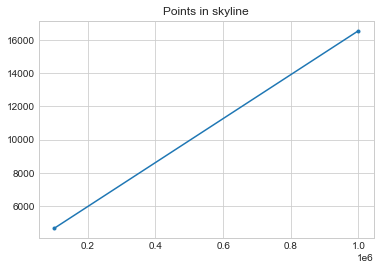

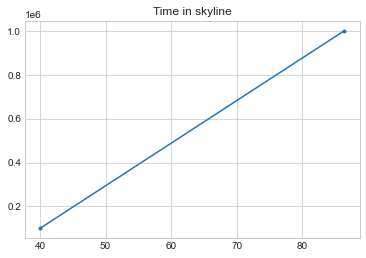

In [18]:
numDim = 4
numDataArray = [1*10**5,1*10**6]

tuplesInSkyline = []
numDataSkyline = []
timeTakenForCalculation = []
for numData in numDataArray:
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.antiCorrelated, numberOfDimensions = numDim,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    dataArray = []
    # Example with one-dimensional slicing Parallel SFS
    sp = parallel_sfs(datapoints, 16)
    # print('~~~~~~~~~~~~~~~~~')
    # spwr = parallel_sfs_with_representatives(datapoints, 8)
    numDataSkyline.append( (len(sp.resultList), numData) )
    timeTakenForCalculation.append( (sp.timeTaken, numData) )
    
helperVisualFunct(numDataSkyline, title = 'Points in skyline', reverseOrder = True)
plt.show()
helperVisualFunct(timeTakenForCalculation, title = 'Time in skyline')
plt.show()

Slices for representative skyline 16
Time taken to find best reps 4.918620824813843
Length of representatives: 111
Length of representatives after skyline query: 107
Time taken to filter: 15.965808153152466
Length of the after filter: 366459
Time taken to find the local skylines: 26.20270276069641
Length of parallel skyline: 25511
Final Serial stage:
~~~~~ Time taken to find the global skyline : 72.7003538608551
~~~~~ Length of the skyline: 24265
~~~~~ Total time taken with representatives: 119.78748559951782


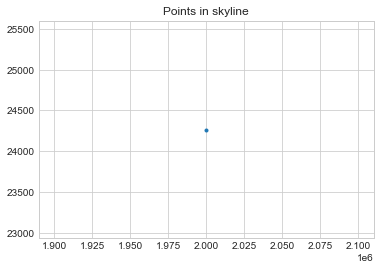

In [21]:
numDim = 4
tuplesInSkyline = []
numDataArray = [2*10**6]
numDataSkyline = []
timeTakenForCalculation = []
for numData in numDataArray:
    dataConfig = DataGenConfig(numberOfData = numData, typeOfCorrelation=DataGenEnum.antiCorrelated, numberOfDimensions = numDim,dataRange = [0,1],  spreadPercentage = 100)
    dataArray = dataGenerator(dataConfig)
    datapoints = normalize_data(dataArray).tolist()
    dataArray = []
    # Example with one-dimensional slicing Parallel SFS with Representative filtering
    spwr = parallel_sfs_with_representatives(datapoints, 16)
    numDataSkyline.append( (len(spwr.resultList), numData) )
    timeTakenForCalculation.append( (spwr.timeTaken, numData) )
    
helperVisualFunct(numDataSkyline, title = 'Points in skyline', reverseOrder = True)

In [ ]:
def all_algorithms():
    # To test the algorithm on a real dataset just use one of the two CSV loading methods
    dataset = get_CSV_Many_SkyPoints(num_col = 2, debug = True)
    datapoints = normalize_data(dataset)
    

    # We can use one of the following commented algorithms
    # Slice on the first dimension and equally partition all data
    parallel_sfs(dataset)
    # Execute BNL on all partitions (dataset is randomly partitioned)
    parallel_bnl(dataset)
    # Same as above but executes SFS
    parallel_sfs_random(dataset)

    # Naive grid partitioning
    naive_grid_partitioning(dataset)
    # Grid partitioning with reduction of test dominations (similar to MR-Sketch and MR-DDT)
    grid_containers_all_parallel(dataset)

    # Naive angle partitioning 
    parallel_angled_partitioning(dataset)

    # Naive angle partitioning but first we find the local skyline within a radius and passes these data to the angled partitioning method
    # with the goal of increasing the accuracy of the dataset
    parallel_radius_partitioning(dataset)

    ####### Slice on the first dimension like parallel_sfs with an added filtering phase before all other computations
    # # The filtering phase here groups points into a squares in a grid and all squares that are dominated by a point within another grid, are removed.
    # # As such, for lower dimensionalities or for independent datasets, the number of test dominations is lowered substantially.
    sfs_index_squares(dataset)
    # # The filtering phase here finds a few points with a big domination area (usually at most 100 points work well)
    # # which then test for domination against all other tuples in the dataset
    parallel_sfs_with_representatives(dataset)

    # This is just a parallel SFS algorithm in which in the global calculation of the skyline is carried through a parallel structure called accumulator
    # In practice it works as good as a serial computation, because accumulators are used mainly for debugging purposes 
    accumulator_skyline(dataset)
    # The same as above but by using pyspark's parallelize method
    parallel_3P(dataset)
